In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv('IPL/train.csv')
df.head()

,Game ID,Team 1,Team 2,City,DayOfWeek,DateOfGame,TimeOfGame,AvgWindSpeed,AvgHumidity,"Inn 1 Team 1 NOP R>25,SR>125",...,"Inn 2 Team 2 NOP R<25, SR>125",Inn 2 Team 2 Total 4s,Inn 2 Team 2 Total 6s,Inn 2 Team 2 Max Strike Rate_ALLBatsmen,Inn 2 Team 1 NoP fast bowlers,Inn 2 Team 1 NoP Spinners,Inn 2 Team 1 wickets taken_catches_runout,Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping,Inn 2 Team 1 Extras conceded in_wides_No Balls,"Winner (team 1=1, team 2=0)"
0,1,Koramangala Traffic Jammers,Whitefield Water Loggers,Whitefield,1,01-01-2012,20:00:00,6,0.49,1,...,0,3,3,120.00,5,0,6,4,11,1
1,2,Electronic City Power Savers,Silkboard Slow Movers,Silkboard,2,01-02-2012,17:00:00,7,0.44,3,...,2,18,9,215.15,4,1,4,0,5,1
2,3,Indranagar Pub Watchers,Sarjapur Water Tankers,Sarjapur,3,01-03-2012,20:30:00,11,0.23,2,...,1,18,1,300.00,3,3,0,1,10,0
3,4,Bellandur Froth Fighters,Koramangala Traffic Jammers,Koramangala,4,01-04-2012,16:00:00,6,0.61,0,...,0,5,4,100.00,4,2,3,2,16,0
4,5,Marathalli Chokers,Whitefield Water Loggers,Marathalli,5,01-05-2012,20:00:00,6,0.56,3,...,3,15,6,205.26,4,2,4,1,5,0


Exploring a bit of the dataset

In [3]:
# a total of 252 observations, 29 features, 1 label
df.shape

(252, 30)

In [4]:
# checking if there are any missing values in any of the observations
# fortunately there is none
df.isnull().sum()

Game ID                                                             0
Team 1                                                              0
Team 2                                                              0
City                                                                0
DayOfWeek                                                           0
DateOfGame                                                          0
TimeOfGame                                                          0
AvgWindSpeed                                                        0
AvgHumidity                                                         0
Inn 1 Team 1 NOP R>25,SR>125                                        0
Inn 1 Team 1 NOP R<25, SR>125                                       0
Inn 1 Team 1 Total 4s                                               0
Inn 1 Team 1 Total 6s                                               0
Inn 1 Team 1 Max Strike Rate_ALLBatsmen                             0
Inn 1 Team 2 NoP fas

In [5]:
# the data is slightly unbalanced, we can ignore it for now
df['Winner (team 1=1, team 2=0)'].value_counts()

0    141
1    111
Name: Winner (team 1=1, team 2=0), dtype: int64

In [6]:
# we can see that Team 1, Team 2, City, DayOfWeek, DateOfGame, TimeOfGame are all strings and need to be converted
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 30 columns):
Game ID                                                             252 non-null int64
Team 1                                                              252 non-null object
Team 2                                                              252 non-null object
City                                                                252 non-null object
DayOfWeek                                                           252 non-null int64
DateOfGame                                                          252 non-null object
TimeOfGame                                                          252 non-null object
AvgWindSpeed                                                        252 non-null int64
AvgHumidity                                                         252 non-null float64
Inn 1 Team 1 NOP R>25,SR>125                                        252 non-null int64
Inn 1 Team 1 NOP R

Starting with a bit of preprocessing where we convert the `object` dtypes into numerical categories, for 'Team 1', 'Team 2', 'City', 'TimeOfGame', 'DateOfGame'.

In [7]:
time_session = [] # 0 represents night, 1 represents evening, 2 represents afternoon extracted from `TimeOfGame`
dates, months, years = [], [], [] # getting the date, month and year out of the `DateOfGame` strings

for index, row in df.iterrows():
    
    match_time = row['TimeOfGame'].split(':')
    
    if int(match_time[0]) >= 20:
        time_session.append(0)
    elif int(match_time[0]) >= 15 and int(match_time[0]) < 20:
        time_session.append(1)
    else:
        time_session.append(2)
    
    match_date = row['DateOfGame'].split('-')
    months.append(match_date[0])
    dates.append(match_date[1])
    years.append(match_date[2])
    
df['time_session'] = time_session
df['months'] = months
df['dates'] = dates
df['years'] = years

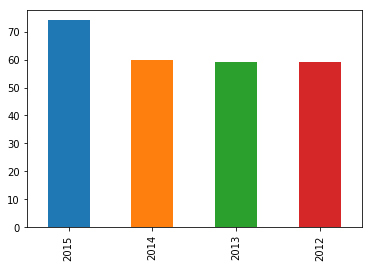

In [8]:
# plot of the above mentioned numbers, it's gaining a lot of traction over the years
df['years'].value_counts().plot(kind='bar', x='year', y='matches conducted')

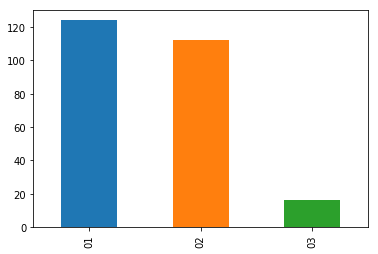

In [9]:
# apparently matches are conducted only during Quarter 1 of every year.
df['months'].value_counts().plot(kind='bar', x='month', y='matches conducted')

In [10]:
# there are 8 cities for the matches
df['City'].value_counts()

Marathalli         47
Sarjapur           40
Koramangala        38
Whitefield         33
Indranagar         27
Electronic City    25
Silkboard          25
Bellandur          17
Name: City, dtype: int64

In [11]:
from sklearn.preprocessing import LabelEncoder
import bisect
city_le = LabelEncoder()
team_name_le = LabelEncoder()

# reading the test file

Exploring a bit of the test dataset

In [12]:
df_test = pd.read_csv('IPL/test.csv')
df_test.head()

,Game ID,Team 1,Team 2,CityOfGame,Day,DateOfGame,TimeOfGame,AvgWindSpeed,AvgHumidity,"Inn 1 Team 1 NOP R>25,SR>125",...,"Inn 2 Team 2 NOP R<25, SR>125",Inn 2 Team 2 Total 4s,Inn 2 Team 2 Total 6s,Inn 2 Team 2 Max Strike Rate_ALLBatsmen,Inn 2 Team 1 NoP fast bowlers,Inn 2 Team 1 NoP Spinners,Inn 2 Team 1 wickets taken_catches_runout,Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping,Inn 2 Team 1 Extras conceded in_wides_No Balls,"Winner (team 1=1, team 2=0)"
0,253,Electronic City Power Savers,Marathalli Chokers,Electronic City,6,01-01-2016,20:00:00,5,0.62,1,...,0,9,5,142.85,3,3,1,1,3,0
1,254,Koramangala Traffic Jammers,Sarjapur Water Tankers,Koramangala,7,01-02-2016,20:00:00,6,0.66,1,...,1,8,4,210.00,3,2,1,1,1,0
2,255,HSR High Rent Payers,Marathalli Chokers,Marathalli,1,01-03-2016,16:00:00,5,0.64,0,...,1,8,1,166.66,4,2,2,7,4,1
3,256,Indranagar Pub Watchers,Silkboard Slow Movers,Indranagar,2,01-04-2016,20:00:00,5,0.64,1,...,3,14,4,166.66,2,4,6,3,2,1
4,257,Whitefield Water Loggers,Sarjapur Water Tankers,Whitefield,3,01-05-2016,16:00:00,5,0.62,2,...,2,13,2,160.00,4,2,6,1,2,1


In [13]:
df_test.shape

(76, 30)

In [14]:
# we can see that test dataset contains a new category called 'HSR' which is not present in the training dataset
df_test['CityOfGame'].value_counts() 

HSR                10
Koramangala        10
Electronic City    10
Whitefield          9
Silkboard           8
Indranagar          8
Marathalli          8
Sarjapur            8
Bellandur           5
Name: CityOfGame, dtype: int64

In [15]:
# two teams from the train are missing but that isn't a problem,
# but a new team has been included in the test dataset but not in train dataset: 'HSR High Rent Payers'
df_test['Team 1'].value_counts()

Electronic City Power Savers    13
Bellandur Froth Fighters        12
Indranagar Pub Watchers         11
Silkboard Slow Movers            8
Koramangala Traffic Jammers      8
Whitefield Water Loggers         7
HSR High Rent Payers             7
Marathalli Chokers               6
Sarjapur Water Tankers           4
Name: Team 1, dtype: int64

In [16]:
time_session = [] # 0 represents night, 1 represents evening, 2 represents afternoon extracted from `TimeOfGame`
dates, months, years = [], [], [] # getting the date, month and year out of the `DateOfGame` strings

for index, row in df_test.iterrows():
    
    match_time = row['TimeOfGame'].split(':')
    
    if int(match_time[0]) >= 20:
        time_session.append(0)
    elif int(match_time[0]) >= 15 and int(match_time[0]) < 20:
        time_session.append(1)
    else:
        time_session.append(2)
    
    match_date = row['DateOfGame'].split('-')
    months.append(match_date[0])
    dates.append(match_date[1])
    years.append(match_date[2])
    
df_test['time_session'] = time_session
df_test['months'] = months
df_test['dates'] = dates
df_test['years'] = years

We can't be optimistic and think that there won't be new teams or new stadiums in the future, therefore it is important to be considerate and include an `other` category in the categorical columns along with other categories present in `train.csv`, this ensures even when unseen data is thrown for any of the following three fields: `Team 1`, `Team 2` and `City`/`CityOfGame`, it can handle it can generalize well and make a bearable prediction at the very least.

In [17]:

# fitting team names from train.csv 
team_name_le.fit(df['Team 1'])

# mapping all the unseen team name categories from test.csv to 'other' i.e., HSR High Rent Payers
df_test['Team 1'] = df_test['Team 1'].map(lambda s: 'other' if s not in team_name_le.classes_ else s)
df_test['Team 2'] = df_test['Team 2'].map(lambda s: 'other' if s not in team_name_le.classes_ else s)

# we include 'other' in the classes for team names
team_name_le_classes = team_name_le.classes_.tolist()
bisect.insort_left(team_name_le_classes, 'other')
team_name_le.classes_ = team_name_le_classes

# now it has an additional class and we can transform the train and test accordingly.
df['team_1_encoded'] = team_name_le.transform(df['Team 1'])
df_test['team_1_encoded'] = team_name_le.transform(df_test['Team 1'])

df['team_2_encoded'] = team_name_le.transform(df['Team 2'])
df_test['team_2_encoded'] = team_name_le.transform(df_test['Team 2'])

In [18]:
# HSR high rent payers has been converted into other, this is how dataset will handle new team names and cities
team_name_le_classes

['Airport Flyers',
 'Bellandur Froth Fighters',
 'Electronic City Power Savers',
 'Forum Fans',
 'Indranagar Pub Watchers',
 'Koramangala Traffic Jammers',
 'Marathalli Chokers ',
 'Sarjapur Water Tankers',
 'Silkboard Slow Movers',
 'Whitefield Water Loggers ',
 'other']

In [19]:
# fitting city names from train.csv 
city_le.fit(df['City'])

# mapping all the unseen team name categories from test.csv to 'other' i.e., 'HSR' 
df_test['CityOfGame'] = df_test['CityOfGame'].map(lambda s: 'other' if s not in city_le.classes_ else s)

# we include 'other' in the classes for city names
city_le_classes = city_le.classes_.tolist()
bisect.insort_left(city_le_classes, 'other')
city_le.classes_ = city_le_classes

# now it has an additional class and we can transform the train and test accordingly.
df['city_encoded'] = city_le.transform(df['City'])
df_test['city_encoded'] = city_le.transform(df_test['CityOfGame'])

In [20]:
city_le.classes_ # HSR in test df is being considered as 'other'

['Bellandur',
 'Electronic City',
 'Indranagar',
 'Koramangala',
 'Marathalli',
 'Sarjapur',
 'Silkboard',
 'Whitefield',
 'other']

In [21]:
# df[['City', 'city_encoded']]  # uncomment this and next cell to verify they mapped fine or not

In [22]:
# df_test[['CityOfGame', 'city_encoded']]

In [23]:
# df[['Team 1', 'team_1_encoded']]

In [24]:
# df_test[['Team 2', 'team_2_encoded']]

In [25]:
df.drop(['Team 1', 'Team 2', 'City', 'Game ID', 'TimeOfGame', 'DateOfGame'], axis = 1, inplace = True)
df_test.drop(['Team 1', 'Team 2', 'CityOfGame', 'Game ID', 'TimeOfGame', 'DateOfGame'], axis = 1, inplace = True)

In [26]:
df.head()

,DayOfWeek,AvgWindSpeed,AvgHumidity,"Inn 1 Team 1 NOP R>25,SR>125","Inn 1 Team 1 NOP R<25, SR>125",Inn 1 Team 1 Total 4s,Inn 1 Team 1 Total 6s,Inn 1 Team 1 Max Strike Rate_ALLBatsmen,Inn 1 Team 2 NoP fast bowlers,Inn 1 Team 2 NoP Spinners,...,Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping,Inn 2 Team 1 Extras conceded in_wides_No Balls,"Winner (team 1=1, team 2=0)",time_session,months,dates,years,team_1_encoded,team_2_encoded,city_encoded
0,1,6,0.49,1,1,15,14,216.43,4,2,...,4,11,1,0,01,01,2012,5,9,7
1,2,7,0.44,3,2,20,16,246.15,5,2,...,0,5,1,1,01,02,2012,2,8,6
2,3,11,0.23,2,2,13,3,200.00,4,1,...,1,10,0,0,01,03,2012,4,7,5
3,4,6,0.61,0,2,6,6,140.00,3,3,...,2,16,0,1,01,04,2012,1,5,3
4,5,6,0.56,3,1,18,5,233.33,5,1,...,1,5,0,0,01,05,2012,6,9,4


In [27]:
# splitting into features and targets
X = df.drop(['Winner (team 1=1, team 2=0)'], axis = 1)
y = df['Winner (team 1=1, team 2=0)']

In [28]:
# taking 80% of the data for training and rest for validation
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [29]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, make_scorer, classification_report, \
roc_auc_score, accuracy_score

In [30]:
# the values are normalized within the range of 0 to 1
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [31]:
# trying to get the top 10 varying principal components
pca = PCA(n_components=10)
pca.fit(X_train_scaled)

X_train_pca10 = pca.transform(X_train_scaled)
X_valid_pca10 = pca.transform(X_valid_scaled)

pca.explained_variance_ratio_

array([0.12984713, 0.10910254, 0.08298632, 0.07494916, 0.06881151,
       0.06151   , 0.05812985, 0.0520743 , 0.04525569, 0.04041722])

In [32]:
# trying to get the top 3 varying principal components
pca = PCA(n_components=3)
pca.fit(X_train)

X_train_pca3 = pca.transform(X_train_scaled)
X_valid_pca3 = pca.transform(X_valid_scaled)

pca.explained_variance_ratio_

array([0.65730944, 0.3208923 , 0.00854764])

In [33]:
# picking only the top 50% contributing/significant features out of all the features based on ANOVA
X_train_reduce50 = SelectPercentile(percentile=50).fit_transform(X_train_scaled, y_train)
X_valid_reduce50 = SelectPercentile(percentile=50).fit_transform(X_valid_scaled, y_valid)

# picking only the top 10% contributing/significant features out of all the features based on ANOVA
X_train_reduce10 = SelectPercentile().fit_transform(X_train_scaled, y_train)
X_valid_reduce10 = SelectPercentile().fit_transform(X_valid_scaled, y_valid)

In [34]:
import warnings
import datetime

# has all the scikit-models in a dictionary with corresponding names
models = {"Logistic Regression": LogisticRegression(), "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
          "Gaussian Naive Bayes": GaussianNB(), "Decision Tree Classifier": DecisionTreeClassifier(),
          "Random Forest Classifier": RandomForestClassifier(), "AdaBoost Classifier": AdaBoostClassifier(),
          "Support Vector Machine": SVC()}

# has all the input data transformations in a dictioanry with corresponding names
data = {"": X_train, "(scaled data)": X_train_scaled, "(PCA: 10 components)": X_train_pca10, "(PCA: 3 components)": X_train_pca3,
        "(50% of features)": X_train_reduce50, "(10% of features)": X_train_reduce10}

res = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for name, model in models.items():
        for scale, X in data.items():
            n = name + " " + scale
            clf = model
            
            # a function which converts a metric function to a callable function
            default_recall = make_scorer(recall_score, pos_label=0, average="binary")
            default_precision = make_scorer(precision_score, pos_label=0, average="binary")
            default_fscore = make_scorer(f1_score, pos_label=0, average="binary")
            default_auc = make_scorer(roc_auc_score)
            
            # taking 3 fold classification average results of the below mentioned metrics over X_train itself
            acc = cross_val_score(clf, X, y_train).mean()
            rec = cross_val_score(clf, X, y_train, scoring=default_recall).mean()
            prec = cross_val_score(clf, X, y_train, scoring=default_precision).mean()
            f1 = cross_val_score(clf, X, y_train, scoring=default_fscore).mean()
            auc = cross_val_score(clf, X, y_train, scoring=default_auc).mean()


            res[n] = {"MeanAccuracy": acc, "Precision": prec, "Recall": rec, "F1Score": f1, 
                      "AUC": auc}

results = pd.DataFrame.from_dict(res, orient="index")
results

,MeanAccuracy,Precision,Recall,F1Score,AUC
AdaBoost Classifier,0.816111,0.836050,0.856197,0.845919,0.807507
AdaBoost Classifier (10% of features),0.845745,0.872679,0.872650,0.870417,0.839543
AdaBoost Classifier (50% of features),0.830597,0.841500,0.880769,0.858853,0.819573
AdaBoost Classifier (PCA: 10 components),0.865428,0.890481,0.880769,0.884277,0.862122
AdaBoost Classifier (PCA: 3 components),0.606610,0.655234,0.694444,0.673993,0.588183
AdaBoost Classifier (scaled data),0.816111,0.836050,0.856197,0.845919,0.807507
Decision Tree Classifier,0.810990,0.814144,0.838889,0.823437,0.792674
Decision Tree Classifier (10% of features),0.845150,0.855814,0.889744,0.868386,0.835524
Decision Tree Classifier (50% of features),0.781726,0.807428,0.855769,0.819322,0.769794
Decision Tree Classifier (PCA: 10 components),0.776315,0.845115,0.796154,0.831298,0.769421


In [35]:
# has the hightest f1-score
results["F1Score"].idxmax(), results["F1Score"].max()

('Logistic Regression (scaled data)', 0.9275081643502695)

In [36]:
# has the highest area under the curve, which seems to be a reasonable metric since data is slightly unbalanced
results["AUC"].idxmax(), results["AUC"].max()

('Logistic Regression (scaled data)', 0.9117996201329536)

From above we can see that linear models like Logistic Regression and Linear Discriminant Analysis have advantage over ensemble and kernel based models.

## XGBoost attempt

In [37]:
import xgboost as xgb

clf = xgb.XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

xgb_param = clf.get_xgb_params()

In [38]:
models = {"XGBoost Classifier": xgb.XGBClassifier()}

data = {"": X_train.values, "(scaled data)": X_train_scaled, "(PCA: 10 components)": X_train_pca10, "(PCA: 3 components)": X_train_pca3,
        "(50% of features)": X_train_reduce50, "(10% of features)": X_train_reduce10}

res = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for name, model in models.items():
        for scale, X in data.items():
                n = name + " " + scale
                clf = model

                xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
                cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=clf.get_params()['n_estimators'], nfold=3,
                                          early_stopping_rounds=50)
                clf.set_params(n_estimators=cvresult.shape[0])
                clf.fit(X_train.values, y_train, eval_metric='auc')            

                default_recall = make_scorer(recall_score, pos_label=0, average="binary")
                default_precision = make_scorer(precision_score, pos_label=0, average="binary")
                default_fscore = make_scorer(f1_score, pos_label=0, average="binary")
                default_auc = make_scorer(roc_auc_score)
                rec = cross_val_score(clf, X, y_train.values, scoring=default_recall).mean()
                prec = cross_val_score(clf, X, y_train.values, scoring=default_precision).mean()
                f1 = cross_val_score(clf, X, y_train.values, scoring=default_fscore).mean()
                auc = cross_val_score(clf, X, y_train.values, scoring=default_auc).mean()
                res[n] = {"MeanAccuracy": acc, "Precision": prec, "Recall": rec, "F1Score": f1, "AUC": auc,}


results_xgb = pd.DataFrame.from_dict(res, orient="index")
results_xgb       

,MeanAccuracy,Precision,Recall,F1Score,AUC
XGBoost Classifier,0.875451,0.889182,0.880983,0.884444,0.861788
XGBoost Classifier (10% of features),0.875451,0.884253,0.898077,0.890890,0.864162
XGBoost Classifier (50% of features),0.875451,0.907172,0.889530,0.897297,0.877966
XGBoost Classifier (PCA: 10 components),0.875451,0.884097,0.855342,0.864182,0.843235
XGBoost Classifier (PCA: 3 components),0.875451,0.611934,0.711325,0.657081,0.536438
XGBoost Classifier (scaled data),0.875451,0.889182,0.880983,0.884444,0.861788


## LightGBM attempt

In [39]:
import lightgbm as lgbm

params = {
    'objective' :'binary',
    'learning_rate' : 0.02,
    'num_leaves' : 76,
    'feature_fraction': 0.64, 
    'bagging_fraction': 0.8, 
    'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'metric': 'auc',
}

In [40]:
from sklearn.model_selection import KFold

models = {"LightGBM Classifier": lgbm}

data = {"": X_train.values, "(scaled data)": X_train_scaled, "(PCA: 10 components)": X_train_pca10, "(PCA: 3 components)": X_train_pca3,
        "(50% of features)": X_train_reduce50, "(10% of features)": X_train_reduce10}

res = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for name, model in models.items():
        for scale, X in data.items():
                n = name + " " + scale
                clf = model

                kfold = KFold(n_splits=3, shuffle=True, random_state=42)
                rec_scores, prec_scores, f1_scores, auc_scores, acc_scores = [], [], [], [], []

                for train_index, valid_index in kfold.split(X):

                    X_t_fold, X_v_fold = X[train_index], X[valid_index]
                    y_t_fold, y_v_fold = y_train.values[train_index], y_train.values[valid_index]

                    d_t_fold = lgbm.Dataset(X_t_fold, y_t_fold)
                    d_v_fold = lgbm.Dataset(X_v_fold, y_v_fold)

                    clf = lgbm.train(params, d_t_fold, 5000, valid_sets=[d_v_fold], verbose_eval=5000, early_stopping_rounds=100)
                    y_pred_fold = clf.predict(X_v_fold)

                    y_pred_fold[y_pred_fold < 0.5] = 0
                    y_pred_fold[y_pred_fold >= 0.5] = 1

                    rec = recall_score(y_v_fold, y_pred_fold)
                    prec = precision_score(y_v_fold, y_pred_fold)
                    f1 = f1_score(y_v_fold, y_pred_fold)
                    auc = roc_auc_score(y_v_fold, y_pred_fold)
                    acc = accuracy_score(y_v_fold, y_pred_fold)

                    rec_scores.append(rec)
                    prec_scores.append(prec)
                    f1_scores.append(f1)
                    auc_scores.append(auc)
                    acc_scores.append(acc)


                res[n] = {"MeanAccuracy": np.mean(acc_scores), "Precision": np.mean(prec_scores), 
                          "Recall": np.mean(rec_scores), "F1Score": np.mean(f1_scores), 
                          "AUC": np.mean(auc_scores)}


results_lgbm = pd.DataFrame.from_dict(res, orient="index")
results_lgbm

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[85]	valid_0's auc: 0.923077
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[107]	valid_0's auc: 0.925926
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[359]	valid_0's auc: 0.959707
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[85]	valid_0's auc: 0.923077
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[107]	valid_0's auc: 0.925926
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[359]	valid_0's auc: 0.959707
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[425]	valid_0's auc: 0.96337
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[554]	val

,MeanAccuracy,Precision,Recall,F1Score,AUC
LightGBM Classifier,0.845771,0.827151,0.794533,0.808127,0.837971
LightGBM Classifier (10% of features),0.771144,0.557778,0.556878,0.556587,0.740405
LightGBM Classifier (50% of features),0.875622,0.825530,0.891975,0.855881,0.878359
LightGBM Classifier (PCA: 10 components),0.825871,0.783626,0.832892,0.798718,0.827985
LightGBM Classifier (PCA: 3 components),0.577114,0.000000,0.000000,0.000000,0.491453
LightGBM Classifier (scaled data),0.845771,0.827151,0.794533,0.808127,0.837971


## Best model so far

The logistic regression model which had good results during cross-validation generalizes well on unseen data

In [41]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
f1_score(y_valid, y_pred)

0.9642857142857143

# Proceeding with test data.

In [42]:
# since y_test is given, we'd like to try and see how well it performs
X_test = df_test.drop(['Winner (team 1=1, team 2=0)'], axis = 1)
y_test = df_test['Winner (team 1=1, team 2=0)']

# Results

In [43]:
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred)

0.8749999999999999

In [44]:
accuracy_score(y_test, y_pred)

0.8947368421052632

In [45]:
y_pred_proba = clf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_proba)

0.9740896358543416

In [46]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.87      0.95      0.91        42
          1       0.93      0.82      0.87        34

avg / total       0.90      0.89      0.89        76



Prediction for each match results can be found in `y_pred` and probabilites of them winning is in `y_pred_proba`.

### The model achieves an `AUC` of ~0.974, accurately classifies upto ~89.47% and has a `f1 score` of 0.875.

## Things I tried that I'd like to mention
1. Firstly, trained the model without DateOfGame and TimeOfGame, the model actually has better accuracy.
2. Secondly, trained the model with Game ID, the model again has better accuracy.
3. Initially used a dictionary to map the team names, and dropped HSR related `CityOfGame`, `Team 1`, `Team 2`from `df_test`, has slightly better accuracy (~91.38%) but at the cost of ~20(out 76) HSR related observations.

but rejected all from a perspective of causal reasoning and federated learning.

### Why?

* DateOfGame and TimeOfGame have a physical significance and anyone can argue a team might be stronger or weaker than how it was. So it should be a cause for making a prediction. 
* Game ID is just a number which keeps on increasing, which can make the learning algorithm think if it's high chances of winning should be low / high, I personally think that's why my DecisionTree failed during that time.
* As mentioned above earlier, we can't assume there won't be new teams or new cities for stadiums, therefore we induce new classes to handle new teams and cities under the roof of `other`, which can help us make predictions based on other features, though it is not advised during a sensitive predictions.

Thank you!